# **Проект**
# **Анализ каталога вин интернет-магазина SimpleWine**
*Выполнили: Амзина Полина и Ким Ми Ра*

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

## Шаг 1: выбор темы


Изначально мы планировали выполнить проект по прогнозированию количества скачиваний приложений с сервисов applestore и googlestore. К сожалению, мы столкнулись с проблемой однообразия данных в готовых датасетах (планировалось объединить несколько) и малой их дифференциацией, в связи с чем было принято решение сменить тему.

В данном проекте мы будем исследовать каталог вин магазина SimpleWine.

## Шаг 2: сбор данных

Сперва нам было необходимо собрать данные с сайта simplewine.ru. Парсинг описан в файле parsing.ipynb. Собранные данные лежат в data.csv. Данные загружаем из этого файла.

## Шаг 3: предварительная обработка

In [2]:
df = pd.read_csv('data.csv', on_bad_lines='skip')
print(df.shape)
df.head()

(5571, 10)


,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75 л.,Simonsig,Стелленбош,шираз 100%,2020 г.,2 990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75 л.,La Scolca,Пьемонт,кортезе 100%,2022 г.,5 990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75 л.,Сикоры,Кубань,красностоп 100%,2018 г.,5 490
3,Vermentino di Toscana,Италия,белое,сухое,0.75 л.,Fattoria del Cerro,Тоскана,верментино,2022 г.,2 490
4,Pfefferer,Италия,белое,полусухое,0.75 л.,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2 490


В датасете содержится о 5571 разновидностях вина

### Описание переменных:
* **name** — название вина
* **country** — страна производства
* **color** — цвет вина
* **sugar** — сладость вина
* **volume** — объем одной бутылки в литрах
* **manufacturer** — производитель
* **region** — регион производства
* **grape** — сорт винограда
* **year** — год производства
* **price** — цена за бутылку в рублях

Посмотрим есть ли в данных пропуски


In [3]:
df.isnull().sum()

name             4
country          0
color            0
sugar            0
volume           0
manufacturer     0
region           0
grape            0
year            76
price            0
dtype: int64

Как можно заметить в данных не хватает 4 наименований вин и 76 годов производства. Так как название вина выступает простым идентификатором и не будет играть большой роли в обучении моделей в дальнейшем, не имеет смысла как-то пытаться заместить пропущенные значения или избавляться от этих товаров. Год производства является весьма важным признаком. Заполнение его средним значением плохо интерпретируемо. Заполнение данного признака медианным тоже может привести к искажению соотношений в данных, поэтому было принято решение удалить вина с пропущенными значениями признака year.

In [4]:
df.dropna(subset=['year'], inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.shape

(5495, 10)

После очистки датасета у нас получилось 5495 элемента, которые мы будем анализировать в дальнейшем

Для дальнейшего анализа необходимо преобразить некоторые столбцы в таблице.

### **Преображение колонки price**

Для перевода строк в числа была написана функция, которая сначала убирает пробелы между разрядами, а потом переводит получившуюся строку в число

In [5]:
def correct_price(value: str):
    correct = int(value.replace(' ', ''))
    return correct

In [6]:
df = pd.DataFrame(df)
price_corrected = df['price'].map(correct_price)

df['price'] = price_corrected
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75 л.,Simonsig,Стелленбош,шираз 100%,2020 г.,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75 л.,La Scolca,Пьемонт,кортезе 100%,2022 г.,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75 л.,Сикоры,Кубань,красностоп 100%,2018 г.,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75 л.,Fattoria del Cerro,Тоскана,верментино,2022 г.,2490
4,Pfefferer,Италия,белое,полусухое,0.75 л.,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2490


### **Преображение колонки grape**

Если вино состоит из нескольких сортов винограда, то при парсинге между видами ставился "&", для дальнейшего анализа мы избавимся от этого разделителя.

In [7]:
def correct_grape(value: str):
    corrected = value.replace('&', ', ')
    return corrected

In [8]:
grape_corrected = df['grape'].map(correct_grape)
df['grape'] = grape_corrected
df.grape.value_counts()

grape
шардоне 100%                                        521
пино нуар 100%                                      507
рислинг 100%                                        232
совиньон блан 100%                                  179
неббиоло 100%                                       152
                                                   ... 
совиньон блан 75%, семильон 23%, мюскадель 2%         1
каберне совиньон 78%, сира 12%, мерло 10%             1
каберне совиньон 64%, мерло 33%, каберне фран 3%      1
каберне совиньон 81%, мерло 16%, каберне фран 3%      1
лембергер (блауфранкиш) 100%                          1
Name: count, Length: 947, dtype: int64

### **Преображение колонки volume**

Для дальнейшей работы необходимо перевести год в числовое значение. Пристальным взглядом (и поломкой кода) было замечено, что для некоторых вин отсутсвовала информация по сладости, в следствие чего при парсинге значения из последующих колонок (объем, мануфактура и тд.) переносились на предыдущие, что крайне осложняло перевод типа данных. В связи с этим было принято решение удалить все вина, у которых произошло смещение данных.

In [9]:
df.volume.value_counts()

volume
0.75 л.             4887
1.5 л.               322
0.375 л.             184
3 л.                  47
0.5 л.                16
тинта баррока          9
турига франка          8
0.187 л.               5
5 л.                   4
6 л.                   3
турига насьональ       2
тинта рориш            2
тинта као              2
9 л.                   2
кодега                 2
Name: count, dtype: int64

Лишние значения в столбце volume: 'турига франка', 'турига насьональ', 'тинта рориш', 'тинта као', 'тинта баррока', 'кодега'.

In [10]:
indices_to_drop = []
for index, item in enumerate(df['volume']):
    if any(word in item for word in ['турига франка', 'турига насьональ', 'тинта рориш', 'тинта као', 'тинта баррока', 'кодега']):
        indices_to_drop.append(index)

df.drop(indices_to_drop, inplace=True)

#Эту функцию написал чат ГПТ. Проводка:
#ind = 0
#for item in df.volume:
  #ind += 1
  #if ('турига франка' or 'турига насьональ' or 'тинта рориш' or 'тинта као' or 'тинта баррока' or 'кодега') in item:
    #df.drop(index = (ind-1) )
#сделать этот код рабочим, так чтобы он удалял строки из таблицы в колонке "объем", которой содержатся 'турига франка' or 'турига насьональ' or 'тинта рориш' or 'тинта као' or 'тинта баррока' or 'кодега'

In [11]:
df.volume.value_counts()

volume
0.75 л.     4887
1.5 л.       322
0.375 л.     184
3 л.          47
0.5 л.        16
0.187 л.       5
5 л.           4
6 л.           3
9 л.           2
Name: count, dtype: int64

Лишние значения удалены. Уберем также единицы измерения.

In [12]:
def correct_volume(value: str):
    corrected = float(value.replace('\xa0л.', ''))
    return corrected

In [13]:
volume_corrected = df['volume'].map(correct_volume)
df['volume'] = volume_corrected
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75,Simonsig,Стелленбош,шираз 100%,2020 г.,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75,La Scolca,Пьемонт,кортезе 100%,2022 г.,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75,Сикоры,Кубань,красностоп 100%,2018 г.,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75,Fattoria del Cerro,Тоскана,верментино,2022 г.,2490
4,Pfefferer,Италия,белое,полусухое,0.75,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023 г.,2490


### **Преображение колонки year**

In [14]:
def correct_year(value: str):
    corrected = int(value.replace('\xa0г.', ''))
    return corrected

In [15]:
year_corrected = df['year'].map(correct_year)
df['year'] = year_corrected
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75,Simonsig,Стелленбош,шираз 100%,2020,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75,La Scolca,Пьемонт,кортезе 100%,2022,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75,Сикоры,Кубань,красностоп 100%,2018,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75,Fattoria del Cerro,Тоскана,верментино,2022,2490
4,Pfefferer,Италия,белое,полусухое,0.75,Colterenzio,Трентино-Альто Адидже,мускат желтый 100%,2023,2490


### Анализ преобразованных данных

Посмотрим, что осталось от изначальных данных.

In [16]:
df.shape

(5470, 10)

В преобразованном датасете 5470 вин.

In [17]:
unique_country = df['country'].nunique()
print("Количество стран производства вина:", unique_country)
unique_manufacturer = df['manufacturer'].nunique()
print("Количество уникальных производителей вина:", unique_manufacturer)
unique_year = df['year'].nunique()
print(f"Датасет охватывает бутылки вина, произведенные в {unique_year} разных годах")

print('\n')
unique_color = df['color'].value_counts()
print("Виды вина по цвету:", unique_color)

print('\n')
unique_sugar = df['sugar'].value_counts()
print("Виды вина по сладости:", unique_sugar)

print('\n')
unique_volume = df['volume'].value_counts()
print("Возможные объёмы бутылки вина:", unique_volume)

Количество стран производства вина: 20
Количество уникальных производителей вина: 518
Датасет охватывает бутылки вина, произведенные в 36 разных годах


Виды вина по цвету: color
красное    3257
белое      2042
розовое     171
Name: count, dtype: int64


Виды вина по сладости: sugar
сухое          4795
полусухое       534
сладкое          86
полусладкое      55
Name: count, dtype: int64


Возможные объёмы бутылки вина: volume
0.750    4887
1.500     322
0.375     184
3.000      47
0.500      16
0.187       5
5.000       4
6.000       3
9.000       2
Name: count, dtype: int64


## Шаг 4. Визуализация

### Данные по объему вина

In [18]:
unique_volume = df['volume'].value_counts()
print("Возможные объёмы бутылки вина:", unique_volume)

Возможные объёмы бутылки вина: volume
0.750    4887
1.500     322
0.375     184
3.000      47
0.500      16
0.187       5
5.000       4
6.000       3
9.000       2
Name: count, dtype: int64


Как можно заметить, вина некоторых объёмов встречаются в данных очень редко. Построим столбчатую диаграмму для объёмов вин, встречающихся в данных более 100 раз.

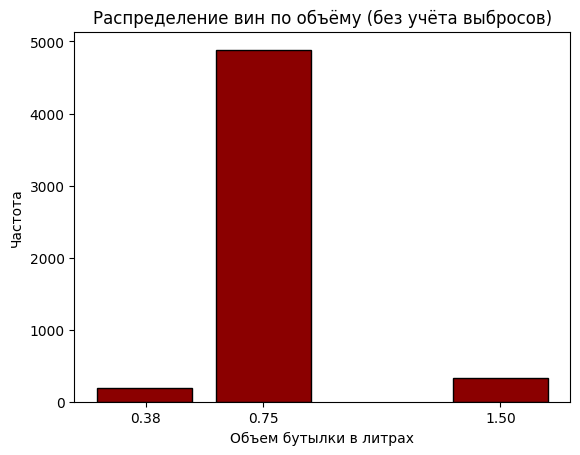

In [19]:
mask = unique_volume.values > 100
x = unique_volume.index[mask]
y = unique_volume.values[mask]

plt.bar(x, y, width=0.3, color='darkred', edgecolor='black')
plt.title(f'Распределение вин по объёму (без учёта выбросов)')
plt.xlabel('Объем бутылки в литрах')
plt.ylabel('Частота')
plt.xticks(list(map(lambda x: round(x, 2), x)))
plt.show()

По диаграмме можно сказать, что на сайте simplewine.ru в основном представлены бутылки вина объемом 0.75 литра.

### Данные по типу вина

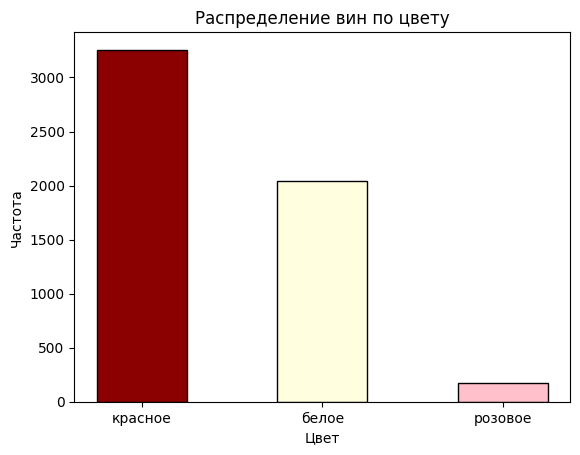

In [20]:
x = df.color.value_counts().index
y = df.color.value_counts().values

plt.bar(x, y, width=0.5, color=['darkred', 'lightyellow', 'pink'], edgecolor='black')
plt.title(f'Распределение вин по цвету')
plt.xlabel('Цвет')
plt.ylabel('Частота')
plt.show()

На гистограмме видно, что больше половины выборки приходится на красные вина. Белые вина также представлены в довольно большом объеме, меньше всего разновидностей розового вина.

### Данные по годам

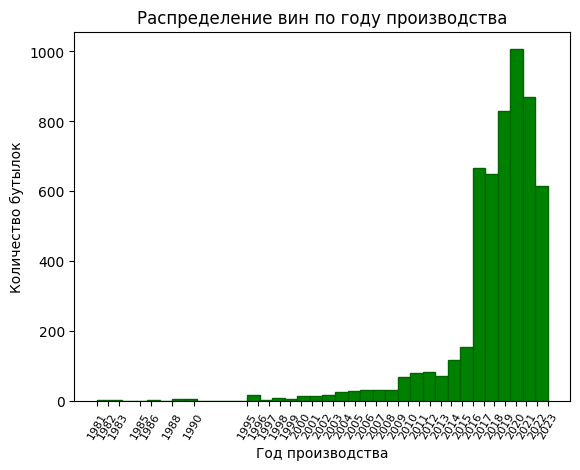

In [21]:
plt.hist(df.year, bins=df.year.nunique(), color='green', edgecolor='darkgreen')
plt.title(f'Распределение вин по году производства')
plt.xlabel('Год производства')
plt.ylabel('Количество бутылок')
plt.xticks(df.year.unique(), rotation=60, fontsize=8)

plt.show()

По данным видно, что большая часть представленных вин произведены не ранее 2016 года. Однако в каталоге встречаются и весьма старые вина, но их немного.



### Данные по стране производства

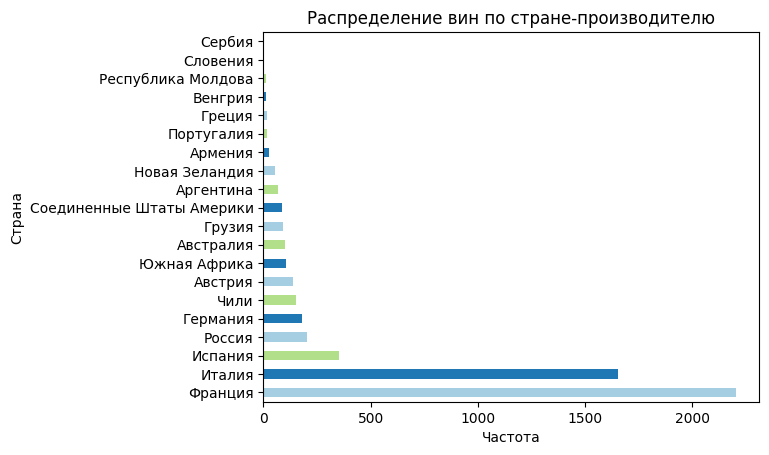

In [22]:
df.country.value_counts().plot.barh(color=sns.color_palette('Paired', len(x)))
plt.title(f'Распределение вин по стране-производителю')
plt.xlabel('Частота')
plt.ylabel('Страна')
plt.show()

plt.show()

Можно заметить, что две страны особо выделяются на фоне остальных. Это Италия и Франция. В последующем мы постоим гистрограмму для континетов. Предсказуемо, Европа будет лидировать.

### Данные о сладости вина

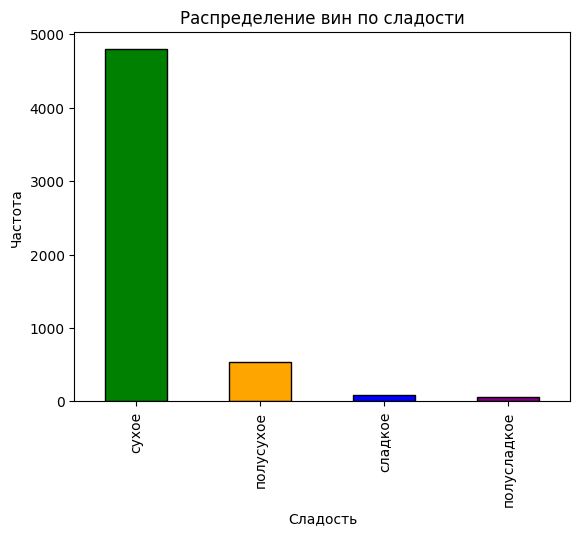

In [23]:
df.sugar.value_counts().plot.bar(color=['green', 'orange',
                                        'blue', 'purple'], edgecolor='black')
plt.title(f'Распределение вин по сладости')
plt.xlabel('Сладость')
plt.ylabel('Частота')
plt.show()

Как можно увидеть выборка в основном представлена сухими винами.

### Обработка выбросов в цене

In [24]:
price_info = df.describe().price

In [25]:
price_info['75%']

17490.0

В исследуемой выборке 75 % вин стоят не дороже 17490 руб.

In [26]:
price_info['max']

1999990.0

In [27]:
df[df.price == price_info['max']]

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
589,Sassicaia,Италия,красное,сухое,6.0,Tenuta San Guido,Тоскана,"каберне совиньон 85%, каберне фран 15%",2018,1999990


В то же время в выборке имеются экстремально высокие значения цен. Максимально возможное значение цены - около 2 млн руб. Это 6-литровая бутылка красного сухого итальянского вина.

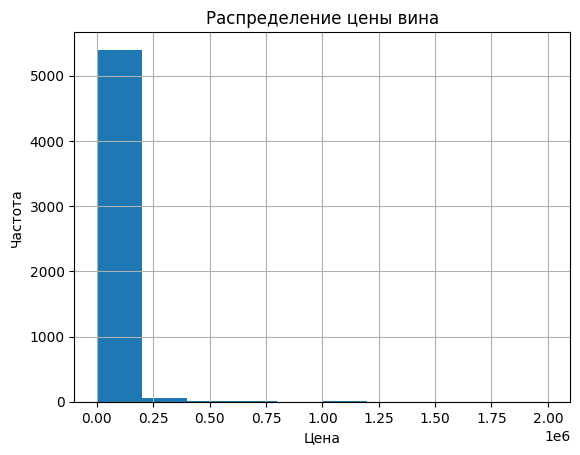

In [28]:
df.price.hist()
plt.title(f'Распределение цены вина')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

По гистограмме можно заметить, что большая часть вин стоит не более 250 тыс.руб. (0.25 * 10^6).



Посмотрим какое значение цены соответсвует диапазону трёх стандартных отклонений от среднего.

In [29]:
price_3_sigma = df.price.mean() + 3 * df.price.std()
price_3_sigma

248768.5845239383

Подтверждая наблюдение, сделанное по графику, мы получили значение около 250 тыс. руб.

In [30]:
(df.price <= 250000).mean()

0.990127970749543

99 % вин в выборке имеют цену не более 250 тыс. руб. Цены больше этого значения будем считать выбросами и исключим из исследования.

In [31]:
mask = df.price > 250000
df.drop(df.index[mask], inplace=True)
df.shape

(5416, 10)

In [32]:
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.tail()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
5411,Pommard,Франция,красное,сухое,0.375,Joseph Drouhin,Бургундия,пино нуар 100%,2018,11190
5412,L`Apparita,Италия,красное,сухое,0.750,Castello di Ama,Тоскана,мерло 100%,2016,67490
5413,Meursault-Charmes Premier Cru Les Charmes Dessus,Франция,белое,сухое,0.750,Domaine Antonin Guyon,Бургундия,шардоне 100%,2020,31490
5414,Saint-Joseph Cavanos,Франция,красное,сухое,0.375,Yves Cuilleron,Долина Роны,сира 100%,2018,4990
5415,Chateau Calon Segur,Франция,красное,сухое,0.750,Chateau Calon Segur,Бордо,"каберне совиньон, мерло, каберне фран, пти вердо",2011,33990


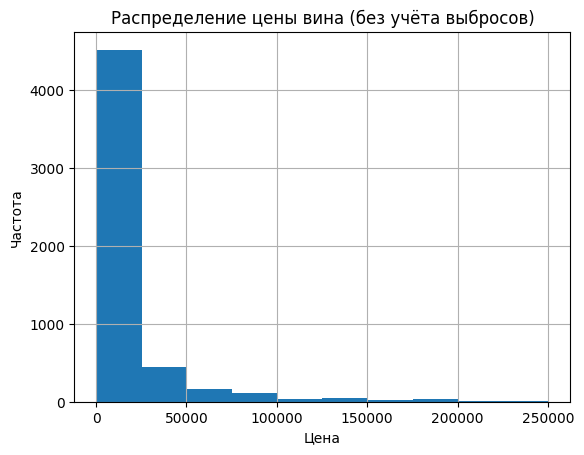

In [33]:
df.price.hist()
plt.title(f'Распределение цены вина (без учёта выбросов)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

### Исследование зависимостей между признаками

Посмотрим на взаимосвязь цены за бутылку вина от её характеристик.

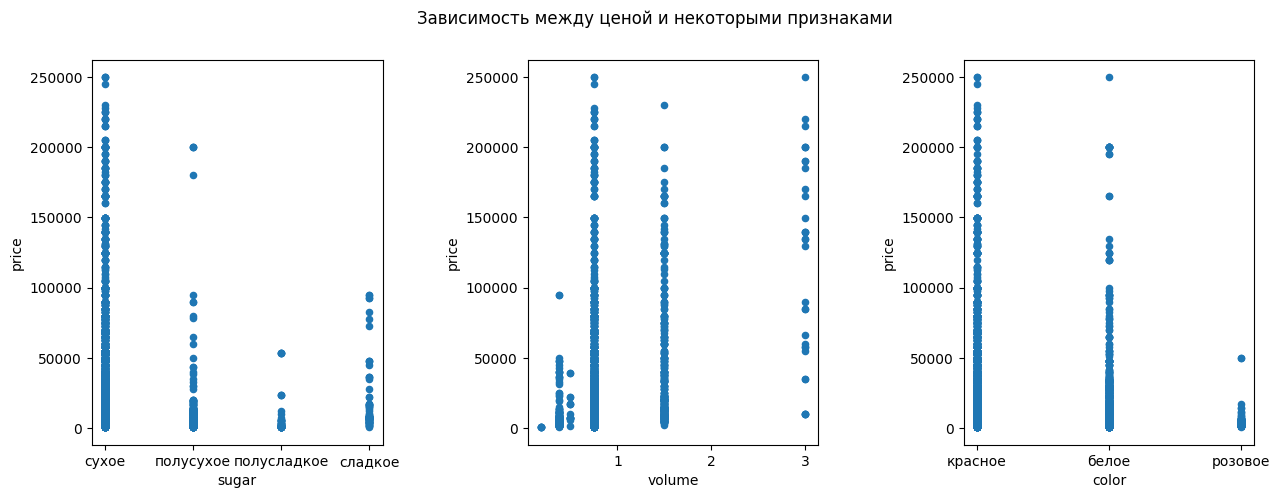

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle('Зависимость между ценой и некоторыми признаками')
df.plot(kind='scatter', x='sugar', y='price', ax=axs[0])
df.plot(kind='scatter', x='volume', y='price', ax=axs[1])
df.plot(kind='scatter', x='color', y='price', ax=axs[2])


plt.subplots_adjust(wspace=0.5)

Как можно увидеть, полусухое, полусладкое и сладкое вино в среднем сильно дешевле сухого. Также красное вино имеет больший разброс цен, чем белое и розовое. Это может быть связано с тем, что в выборке представлено больше красного вина. Про объем можно лишь сказать, что имеется очень сильный разброс значений. В целом по диаграмме рассеяния можно отметить присутствие положительной корреляции - чем больше объём бутылки вина, тем выше её цена.

## Шаг 5. Создание новых признаков

### **Новый признак колонки country**

In [35]:
unique_countries = df['country'].unique()
print("Страны - производители вина:", unique_countries)

Страны - производители вина: ['Южная Африка' 'Италия' 'Россия' 'Аргентина' 'Франция' 'Испания'
 'Австралия' 'Германия' 'Австрия' 'Новая Зеландия' 'Чили' 'Португалия'
 'Грузия' 'Венгрия' 'Армения' 'Соединенные Штаты Америки' 'Греция'
 'Республика Молдова' 'Словения' 'Сербия']


Так как в данных представлены с разных континентов, то для дальнейшей работы было решено объединить страны по частям света. Так, к Европе относятся: Италия, Россия, Франция, Испания, Германия, Австрия, Португалия, Грузия, Венгрия, Армения, Греция, Республика Молдова, Словения, Сербия. К Америке: Аргентина, Чили, Соединенные Штаты Америки. Африку представляет Южная Африка. Океанию - Австралия и Новая Зеландия.

In [36]:
Africa = ['Южная Африка']
Europe = ['Италия', 'Россия', 'Франция', 'Испания', 'Германия', 'Австрия', 'Португалия', 'Грузия', 'Венгрия',
 'Армения', 'Греция', 'Республика Молдова', 'Словения', 'Сербия']
America = ['Аргентина', 'Соединенные Штаты Америки', 'Чили']
Oceania = ['Новая Зеландия', 'Австралия']

In [37]:
def region(x):
  if x in Africa:
    return 'Africa'
  elif x in Europe:
    return 'Europe'
  elif x in America:
    return 'America'
  else:
    return 'Oceania'

In [38]:
df['region'] = df['country'].apply(region)
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75,Simonsig,Africa,шираз 100%,2020,2990
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75,La Scolca,Europe,кортезе 100%,2022,5990
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75,Сикоры,Europe,красностоп 100%,2018,5490
3,Vermentino di Toscana,Италия,белое,сухое,0.75,Fattoria del Cerro,Europe,верментино,2022,2490
4,Pfefferer,Италия,белое,полусухое,0.75,Colterenzio,Europe,мускат желтый 100%,2023,2490


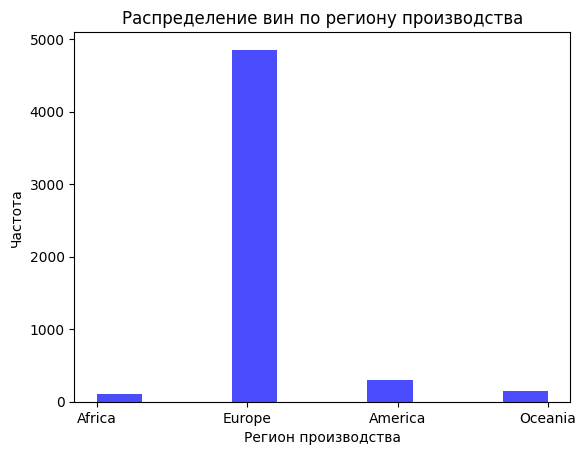

In [39]:
plt.hist(df['region'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Регион производства')
plt.ylabel('Частота')
plt.title('Распределение вин по региону производства')
plt.show()

### **Новый признак колонки year**

In [40]:
sorted(df['year'].unique())

[1981,
 1982,
 1983,
 1985,
 1986,
 1988,
 1990,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

In [41]:
grand = range(1981, 2000)
old = range(2000, 2010)
new = range(2010, 2020)
baby = range(2020, 2024)

In [42]:
def time(x):
  if x in grand:
    return '1980 - 1999'
  elif x in old:
    return '2000 - 2009'
  elif x in new:
    return '2010 - 2019'
  else:
    return '2020 - 2023'

In [43]:
df['period of time'] = df['year'].apply(time)
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price,period of time
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75,Simonsig,Africa,шираз 100%,2020,2990,2020 - 2023
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75,La Scolca,Europe,кортезе 100%,2022,5990,2020 - 2023
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75,Сикоры,Europe,красностоп 100%,2018,5490,2010 - 2019
3,Vermentino di Toscana,Италия,белое,сухое,0.75,Fattoria del Cerro,Europe,верментино,2022,2490,2020 - 2023
4,Pfefferer,Италия,белое,полусухое,0.75,Colterenzio,Europe,мускат желтый 100%,2023,2490,2020 - 2023


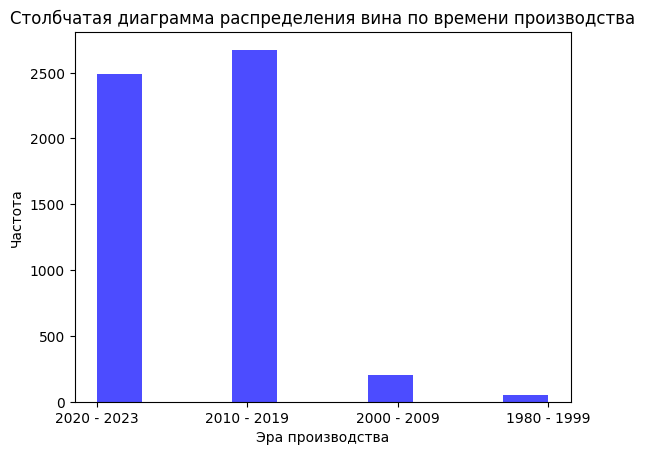

In [44]:
plt.hist(df['period of time'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Эра производства')
plt.ylabel('Частота')
plt.title('Столбчатая диаграмма распределения вина по времени производства')
plt.show()

### **Новый признак колонки цена**

In [45]:
 a = df['price'].quantile(0.25)
 b = df['price'].quantile(0.5)
 c = df['price'].quantile(0.75)

Для создании категории "costliness" разобьем вина по их стоимости. Назовем вина, цена которых ниже первого квантиля, дешевыми. Винами "ниже среднего" будут названы вина, чья цена лежит в промежутке от первого до второго квантиля. Далее будут вина "выше среднего", а те вина, чья цена выше 3 квантиля будут называться "дорогими"

In [46]:
def price_label(x):
  if x < a:
    return "cheap"
  elif a <= x < b:
    return 'below average'
  elif b <= x < c:
    return 'above average'
  else:
    return 'expensive'

In [47]:
df['costliness'] = df['price'].apply(price_label)
df.head()

,name,country,color,sugar,volume,manufacturer,region,grape,year,price,period of time,costliness
0,Shiraz Mr Borio's,Южная Африка,красное,сухое,0.75,Simonsig,Africa,шираз 100%,2020,2990,2020 - 2023,cheap
1,Gavi dei Gavi (Etichetta Nera),Италия,белое,сухое,0.75,La Scolca,Europe,кортезе 100%,2022,5990,2020 - 2023,below average
2,Красностоп Золотовский на Террасах,Россия,красное,сухое,0.75,Сикоры,Europe,красностоп 100%,2018,5490,2010 - 2019,below average
3,Vermentino di Toscana,Италия,белое,сухое,0.75,Fattoria del Cerro,Europe,верментино,2022,2490,2020 - 2023,cheap
4,Pfefferer,Италия,белое,полусухое,0.75,Colterenzio,Europe,мускат желтый 100%,2023,2490,2020 - 2023,cheap


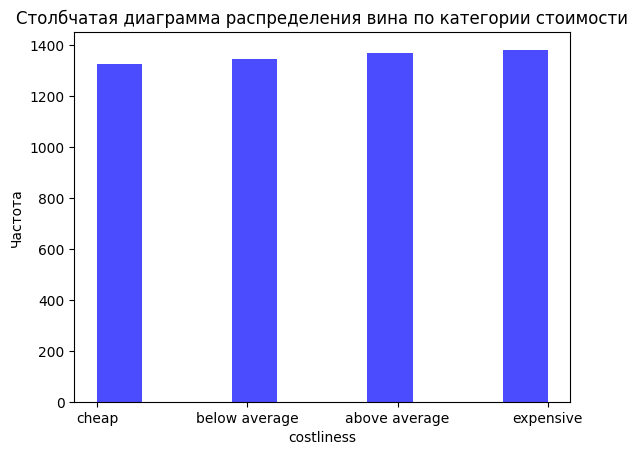

In [48]:
plt.hist(df['costliness'], bins=10, color='blue', alpha=0.7)
plt.xlabel('costliness')
plt.ylabel('Частота')
plt.title('Столбчатая диаграмма распределения вина по категории стоимости')
plt.show()

 ##  Шаг 6. Гипотезы

### Гипотеза 1: Объем бутылки вина положительно коррелирует с ценой


Для проверки этой гипотезы раасчитаем коэфициент линейной корреляции Пирсона.

In [82]:
df['price'].corr(df['volume'])

0.3483829731036283

Как мы видим коэфициент линейной корреляции Пирсона составляет 0.35, что говорит о положительной линейной взаимосвязи. Однако, учитывая модуль коэфициента, можно сказать, что связь не сильная.

### Гипотеза 2

**H0:** Красное сухое вино будет в среднем стоить также, как другие виды вина

**H1:** Красное сухое вино будет в среднем стоить дороже, чем другие виды вина

In [83]:
red_dry = df[(df['color'] == 'красное') & (df['sugar'] == 'сухое')]
others = df[(df['color'] != 'красное') | (df['sugar'] != 'сухое')]

Для проверки гипотезы воспользуемся парным t-критерием с уровнем значимости 10%.

In [84]:
from scipy import stats
res = stats.ttest_ind(red_dry['price'], others['price'], alternative='greater')

In [85]:
res.pvalue < 0.1

True

p-value < alpha, нулевая гипотеза отвергается. Различия в цене между красным сухим вином и другими винами статистически значимы (красное сухое вино дороже).

### Гипотеза 3: Чем меньше год производства вина, тем оно будет стоить дороже

In [86]:
df['price'].corr(df['year'])

-0.5061783680913556

Вычислив коэфициент линейной корреляции Пирсона, мы можем утверждать, что цена бутылки и её год производства имеют орицательную корреляцию. Это означает, что с ростом года производства цена бутылки будет снижаться

### Гипотеза 4

**H0:** Вино, произведённое во Франции, будет в среднем стоить также, как другие виды вина

**H1:** Вино, произведённое во Франции, будет в среднем стоить дороже, как другие виды вина

In [87]:
french = df[df['country'] == 'Франция']
not_french = df[df['country'] != 'Франция']

Для проверки гипотезы воспользуемся парным t-критерием с уровнем значимости 10%.

In [88]:
from scipy import stats
res = stats.ttest_ind(french['price'], not_french['price'], alternative='greater')

In [89]:
res.pvalue < 0.1

True

p-value < alpha, нулевая гипотеза отвергается. Различия в цене между французским вином и другими винами статистически значимы (французское вино дороже).

## Шаг 7. Машинное обучение

### Постановка задачи и подготовка данных

Изначально нами рассматривался вариант решения задачи регрессии - предсказания цены вина на основе имеющихся характеристик, однако из числовых характеристик нам удалось собрать лишь объём и год производства (возраст вина), что, на наш взгляд, не позволит найти хорошее решение подобной задачи. Поэтому мы решили остановится на задаче многоклассовой классификации - предсказания принадлежности вина к одному из ранее выделенных 4 ценовых сегментов ('cheap', 'below average', 'above average', 'expensive'). Так как порогами для разделения на 4 класса были квартили распределения цен, то выборка является сбалансированной по классам по построению (к каждому из классов отнесено примерно 25% выборки).

Цель - обучить модель, относящую вино к определённому ценовому сегменту на основе признаков color, sugar, volume, region, period of time. Признак volume - количественный, остальные признаки - категориальные. Признаки region и period of time - агрегированные признаки по столбцам country и year.

In [49]:
df_ml = df[['color', 'sugar', 'volume', 'region', 'period of time', 'costliness']]
df_ml.head()

,color,sugar,volume,region,period of time,costliness
0,красное,сухое,0.75,Africa,2020 - 2023,cheap
1,белое,сухое,0.75,Europe,2020 - 2023,below average
2,красное,сухое,0.75,Europe,2010 - 2019,below average
3,белое,сухое,0.75,Europe,2020 - 2023,cheap
4,белое,полусухое,0.75,Europe,2020 - 2023,cheap


Закодируем категории в категориальных переменных натуральными числами с помощью LabelEncoder. Аналогично преобразуем столбец целевой переменной.

In [50]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat = ['color', 'sugar', 'region', 'period of time', 'costliness']
for column in cat:
  df_ml[column] = le.fit_transform(df_ml[column].values)
df_ml.head()

<ipython-input-50-0b099bd75fb6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml[column] = le.fit_transform(df_ml[column].values)
<ipython-input-50-0b099bd75fb6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml[column] = le.fit_transform(df_ml[column].values)
<ipython-input-50-0b099bd75fb6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,color,sugar,volume,region,period of time,costliness
0,1,3,0.75,0,3,2
1,0,3,0.75,2,3,1
2,1,3,0.75,2,2,1
3,0,3,0.75,2,3,2
4,0,1,0.75,2,3,2


В переменную X запишем матрицу объект-признаки, в y - значения целевой переменной.

In [51]:
X = df_ml.drop('costliness', axis=1)
y = df_ml.costliness.values

Разделим данные на обучающую и тренировочную выборки. Размер теста - 30%.

In [52]:
from sklearn.model_selection import train_test_split, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Бэггинг

Для задачи многоклассовой классификации можно использовать, например, композицию деревьев принятия решений - бэггинг или случайный лес.

In [53]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Обучим BaggingClassifier на 100 деревьях. Для оценки качества классификации будем использовать метрикy accuracy (доля правильных ответов).

In [54]:
base_tree = DecisionTreeClassifier()
bag = BaggingClassifier(base_tree, n_estimators=100, n_jobs=4, random_state=111)
bag.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=4, random_state=111)

In [55]:
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred_test)}')

Accuracy Train: 0.47058823529411764
Accuracy Test: 0.4633846153846154


Доля правильных ответов на обучающей выборке составила 47 %, на тестовой выборке - 46.3%. То есть обученная модель неверно распознает ценовой сегмент более чем на половине рассматриваемых объектов.

### Случайный лес

Обучим Random Forest на 100 деревьях и посмотрим, будет ли эта модель лучше по качеству. Для оценки качества модели снова используем accuracy.

С помощью кросс-валидации на обучающей выбрке подберем оптимальные значения гиперпараметров max_depth (максимальная глубина дерева) и min_samples_split (минимальное число объектов в вершине для разбиения). Для этого зададим значения для перебора, и для каждой пары таких значений проведем кросс-валидацию на обучающей выборке (количество разбиений обучающей выборке установим равным 10). В качестве критерия оценки качества пары гиперпараметров будем использовать f1_macro - среднее значение f-мер, рассчитанных для каждого из четырёх классов (если бы мы решали для каждого из них задачу бинарной классификации). Оптимальной будет пара гиперпараметров, максимизирующая этот критерий.

In [56]:
# значения для перебора
max_depth_s = range(1, 21)
min_samples_split_s = range(2, 21)

f1_best = 0
for i in max_depth_s:
  for j in min_samples_split_s:
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=i, min_samples_split=j, random_state=333, n_jobs=4
        )
    scores = cross_validate(rf, X_train, y_train, cv=10, scoring='f1_macro')
    f1_avg = np.mean(scores['test_score'])
    if f1_avg > f1_best:
      best = (i, j)
      f1_best = f1_avg
print(best, f1_best)

(9, 2) 0.4502610976365008


Наиучшее среднее качество дают max_depth=9, min_samples_split=2.

In [57]:
# обучаем случайный лес с подобранными гиперпараметрами
rf = RandomForestClassifier(
        n_estimators=100, max_depth=9, min_samples_split=2, random_state=333, n_jobs=4
        )
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_jobs=4, random_state=333)

In [58]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred_test)}')

Accuracy Train: 0.47058823529411764
Accuracy Test: 0.46153846153846156


Доля правильных ответов на обучающей выборке составила 47 %, на тестовой выборке - 46.2%. То есть случайный лес по качеству оказался близок к бэггингу.

### KNN

Попробуем обучить модель kNN. Данная модель также подходит для решения задачи многоклассовой классификации - класс нового объекта определяется как наиболее часто встречающийся класс из k его ближайших соседей.

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

Чтобы расстояния между объектами вычислялись корректно (все признаки вносили одинаковый вклад), проведем масштабирование признаков, используя StandardScaler.

In [60]:
# масштабирование признаков
sc = StandardScaler().fit(X_train)
X_train_norm = sc.transform(X_train)
X_train_norm = pd.DataFrame(data=X_train_norm)
X_test_norm = sc.transform(X_test)
X_test_norm = pd.DataFrame(data=X_test_norm)

Обучим модели с разными значениями гиперпараметра k. В качестве метрики качества используем Accuracy.

In [61]:
k = np.array([3, 5, 10, 15, 25, 35, 55, 75, 101, 201, 301])  # значения для перебора
n = len(k)
acc_train = np.zeros(n)
acc_test = np.zeros(n)

for i in range(n):
  # обучение класссификатора
  clf = KNeighborsClassifier(n_neighbors=k[i], p=2, n_jobs=10)  # p=2 задает евклидово расстояние
  clf.fit(X_train_norm, y_train)
  # предсказание модели
  y_pred_train = clf.predict(X_train_norm)
  y_pred_test = clf.predict(X_test_norm)
  # доля правильных ответов
  acc_train[i] = accuracy_score(y_train, y_pred_train)
  acc_test[i] = accuracy_score(y_test, y_pred_test)


dct = {'k' : k, 'Accuracy Train': acc_train, 'Accuracy Test': acc_test}
results_knn = pd.DataFrame(dct)
results_knn

,k,Accuracy Train,Accuracy Test
0,3,0.422316,0.393846
1,5,0.417304,0.399385
2,10,0.450277,0.444923
3,15,0.449486,0.444308
4,25,0.444210,0.441231
5,35,0.453179,0.454769
6,55,0.443682,0.460923
7,75,0.446848,0.443692
8,101,0.422844,0.433231
9,201,0.433659,0.451692


Среди обученных классификаторов наилучшее качество на тесте даёт модель с k=55: доля правильных ответов на тесте 46%, на обучающей выборке - 44.4%.

### Выводы

Для решения задачи классификации вин по 4 ценовым сегментам были обучены модели BaggingClassifier, RandomForestClassifier и KNeighborsClassifier. Композиции решающих деревьев оказались чуть лучше, чем KNeighborsClassifier, однако все три модели получились не очень хорошими по качеству - доля правильных ответов во всех случаях как на обучающей, так и на тестовой выборке менее 50%. На данный результат могла повлиять ограниченность используемых при решении задачи признаков.